In [20]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
from scipy.optimize import minimize
import time    

import pickle

In [49]:
GP_nominal= pickle.load(open(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_ROBOTARIUM\GP_nominal.dump','rb'))

In [68]:
control_space_size = 5

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size))
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size))
time_step = 0.033

In [31]:
def model_step(x,velocities,time_step):
    """
    Actual System Model P(.)
    Args:
        x (array): State
        velocities (array): Control velocities
        time_step (float): Time step
    Returns:
        array: Next state
    """
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    
    return(poses)


def nominal_model_step(x,velocities,time_step):
    """
    Nominal System Model P^{bar}(.)
    Args:
        x (array): State
        velocities (array): Control velocities
        time_step (float): Time step
    Returns:
        array: Nominal next state
    """
    poses = np.zeros((2,1))
    
    # Update dynamics of agents
    poses[0] = 1.0*x[0] + time_step*velocities[0] + 0.1*x[0]
    poses[1] = 1.0*x[1] + time_step*velocities[1] + 0.1*x[1]
    
    return(poses)

def logpdf(x, u, covar):
    """
    Gaussian kernel
    Args:
        x (array): Current state
        u (array): Obstacle points
        covar (array): Covariance
    Returns:
        float: Probability of hitting the obstacle
    """
    
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

import numpy as np


def goal_cost(state,goal_points):
    """
    Calculate cost based on the distance between goal point and current robot state
    Args:
        state (array): Current state
        goal_points (array): Goal points
    Returns:
        float: Cost
    """
        
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) 
   
    return(cost)

def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def multivariate_rbf_kernel(X1, X2, gamma):
    #Compute the multivariate Radial Basis Function (RBF) kernel between two sets of input points.
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))

    diff = X1[:] - X2[:]
    K = np.exp(-gamma * np.dot(diff, diff))

    return K

In [32]:
def state_cost(state,goal_points,obs_points):
    """
    Calculate state cost considering goal and obstacles
    Args:
        state (array): Current state
        goal_points (array): Goal points
        obs_points (array): Obstacle points
    Returns:
        float: State cost
    """
    
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*logpdf(state[:2],obs_points[:2,i],covar)
        
    cost = 50*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 2*(np.exp(-0.5*((state[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
    
    return(cost)

def state_cost_with_weights(state,goal_points,obs_points,weights):
    """
    Calculate state cost considering goal and obstacles using weights
    Args:
        state (array): Current state
        goal_points (array): Goal points
        obs_points (array): Obstacle points
        weights (array): Weights for cost computation
    Returns:
        float: State cost
    """
    
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[0,i+1]*logpdf(state[:2],obs_points[:2,i],covar)
        
    cost = -weights[0,0]*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 1*(np.exp(-0.5*((state[0]-(-1.5))/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.03)**2)/(0.03*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[1]-(-1.0))/0.03)**2)/(0.03*np.sqrt(2*np.pi)))
    
    return(cost)

In [34]:
def calculate_kl_divergence(mu1, cov1, mu2, cov2):
    """
    Calculate the Kullback-Leibler (KL) divergence between two multivariate Gaussian distributions.

    Args:
        mu1: numpy array of shape (d,), the mean vector of the first Gaussian distribution
        cov1: numpy array of shape (d, d), the covariance matrix of the first Gaussian distribution
        mu2: numpy array of shape (d,), the mean vector of the second Gaussian distribution
        cov2: numpy array of shape (d, d), the covariance matrix of the second Gaussian distribution

    Returns:
        kl_divergence: float, the KL divergence between the two Gaussian distributions
    """
    d = len(mu1)

    # Invert the covariance matrix of the second Gaussian distribution
    cov2_inv = np.linalg.inv(cov2)

    # Calculate the trace term
    trace_term = np.trace(np.matmul(cov2_inv, cov1))

    # Calculate the squared difference in means
    mean_diff = mu2 - mu1
    mean_diff_term = np.dot(np.dot(mean_diff, cov2_inv), mean_diff)

    # Calculate the log-determinant term
    log_det_term = np.log(np.linalg.det(cov2) / np.linalg.det(cov1))

    # Calculate the KL divergence
    kl_divergence = 0.5 * (trace_term + mean_diff_term - d + log_det_term)

    return kl_divergence

In [35]:
def is_inside_rectangle(state, bottom_left, top_right):
    """
    Check if the state is inside the rectangular region.

    Args:
        state (list or numpy.ndarray): State as a 2D point [x, y].
        bottom_left (list): Bottom-left corner of the rectangle [x_min, y_min].
        top_right (list): Top-right corner of the rectangle [x_max, y_max].

    Returns:
        bool: True if the state is inside the rectangle, False otherwise.
    """
    return bottom_left[0] <= state[0] <= top_right[0] and bottom_left[1] <= state[1] <= top_right[1]


def C_tilde(Costs,eta,nominal_prob,reference_prob):
    """
    Calculate C_tilde for cost transformation
    Args:
        Costs (array): Costs array
        eta (float): radius of the KL ball
    Returns:
        float: Transformed cost
    """
    
    def objective(alpha):
        alpha = alpha[0]
        if alpha < 0.0:
            return np.inf  # Return a large number if alpha is non-positive
        term1 = alpha * eta

        term2 = alpha * np.log(np.sum(nominal_prob*((nominal_prob/reference_prob)*np.exp(np.array(Costs)))**(1/alpha)))
        return term1 + term2
    
    # Initial guess for alpha
    initial_guess = [1.0]

    # Constraint definition for scipy.optimize.minimize
    constraints = [
        {'type': 'ineq', 'fun': lambda alpha: alpha[0]-0.0}  # alpha > 0
    ]
    
    # Solve the problem
    result = minimize(objective, initial_guess,constraints=constraints)
    c_tilde = np.min([np.max(np.log((nominal_prob/reference_prob)*np.exp(np.array(Costs)))),result.fun])
    
    return c_tilde

    
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
    
    """
    Perform an control step given an expert input
    Args:
        state (array): Current state
        U_space_1 (array): Action space for 1st input
        U_space_2 (array): Action space for 2nd input
        goal_points (array): Goal points
        obs_points (array): Obstacle points
    Returns:
        array: Action
    """

    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    for i in range(control_space_size):
        for j in range(control_space_size):
            test_input = np.hstack((state.reshape(-1,), np.array([U_space_1[i],U_space_2[j]]))).reshape(1, -1)
            # next_state_nominal = nominal_model_step(state,np.array([U_space_1[i],U_space_2[j]]),time_step)
            next_state_nominal, sigma_nom = GP_nominal.predict(test_input,return_cov=True)
            cov_nom = np.diag(sigma_nom.reshape((2,)))
            # cov_nom = np.array([[0.0001, 0.00002], [0.00002, 0.0001]])
            p_bar = st.multivariate_normal(next_state_nominal.reshape((2,)),cov_nom)
            N_samples = 10
            next_sample = p_bar.rvs(N_samples)
            nominal_pdf = p_bar.pdf(next_sample)
            nominal_prob = nominal_pdf/np.sum(nominal_pdf) 
            
            
            next_state_reference = goal_points[:-1]
            cov_reference = np.array([[0.0001, 0.00002], [0.00002, 0.0001]])
            q = st.multivariate_normal(next_state_reference.reshape((2,)),cov_reference)
            nextq_sample= q.rvs(N_samples)
            reference_pdf = q.pdf(nextq_sample)
            reference_prob = reference_pdf/np.sum(reference_pdf)
           
            
            
            eta = np.clip(calculate_kl_divergence(goal_points[:-1].reshape((2,)),cov_reference,next_state_nominal.T.reshape((2,)),cov_nom),0.0,100.0)
            
            DKL = calculate_kl_divergence(next_state_nominal.T.reshape((2,)),cov_nom,goal_points[:-1].reshape((2,)),cov_reference)
            
            cost = [state_cost(next_sample[i,:],goal_points,obs_points) for i in range(N_samples)]
            
            # DR algorithm 
            c_t = C_tilde(cost,eta,nominal_prob,reference_prob)
            log_DKL = np.exp(-eta-c_t)
            
            # uncomment following line to implement FPD, and comment line no. 370 and 371
            # log_DKL = np.exp(-DKL-np.sum(cost)/N_samples)
            
            if log_DKL == 0.0:
                log_DKL = 1e-10
                 
            pf[i,j] = log_DKL
    S2 = np.sum(pf) #Normalize resulting policy

    pf = np.array([x/S2 for x in pf])
            
    flat = pf.flatten()

    sample_index = np.random.choice(a=flat.size, p=flat)

    # Take this index and adjust it so it matches the original array
    adjusted_index = np.unravel_index(sample_index, pf.shape)

    action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))
    
    return(action,pf)
    

In [36]:
# Define goal points by removing orientation from poses
goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))

In [38]:
%%capture
# Instantiate Robotarium object
N = 1
M = 1

initial_conditions = [np.array(np.mat('1.3;0.8; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]

XX = [0]*M
UU = [0]*M
XN = [0]*M
COVN = [0]*M

for I in range(M):
    
    D_xi = []
    X_si = []
    X_si_nom = []
    Cov_si_nom = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    # Create single integrator position controller
    single_integrator_position_controller = create_si_position_controller()

    # Create barrier certificates to avoid collision
    #si_barrier_cert = create_single_integrator_barrier_certificate()
    si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

    _, uni_to_si_states = create_si_to_uni_mapping()

    # Create mapping from single integrator velocity commands to unicycle velocity commands
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    # define x initially
    x = r.get_poses()
    x_si = uni_to_si_states(x)
    X_si_nom.append(x_si)
    
    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.1
    obs_marker_size_m = 0.1
    #robot_marker_size_m = 0.1
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    #marker_size_robot = determine_marker_size(r, robot_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]
    

    # Create obstacle markers
    #Text with obstacle identification
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    #Plot text for caption
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]
    
    # gt_img = plt.imread(r'robotarium_environemnt.jpg')
    # x_img = np.linspace(-1.5, 1.5, gt_img.shape[1])
    # y_img = np.linspace(-1.0, 1.0, gt_img.shape[0])

    # gt_img_handle = r.axes.imshow(gt_img, extent=(-1.7, 1.67, -1.091, 1.07))
    
    position_history=np.empty((2,0))
    k = 0
    r.step()
    
        # While the number of robots at the required poses is less
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.25,rotation_error=100)) != N):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)
        X_si.append(x_si)
        
        obs_points_col = obs_points[:-1]
        # Loop through each column in obs_points and compare with X
        for i in range(obs_points.shape[1]):
            column = obs_points[:, i]
    
            # Check if the current column matches X
            if np.array_equal(column, x_si):
                print(f"Crashed into obstacle at {i}: {column}")
                break
            
        if x_si[0] <= np.array([-1.5]) or x_si[0] >= np.array([1.5])  or x_si[1] <= np.array([-1.0]) or x_si[1] >= np.array([1.0]):
            print('Touched the boundary wall')
            
            break
        
        if is_inside_rectangle(x_si, [-0.25,-0.25],[0.15,0.85] ):
            print(f"State entered the rectangle at: {x_si}")
            break
        
        position_history=np.append(position_history, x[:2],axis=1)
        r.axes.scatter(position_history[0,:],position_history[1,:], s=1, linewidth=4, color='b',linestyle='dashed')

        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])
        
        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Create single-integrator control inputs
        
        dxi, u_pf = Control_step(x_si,U_space_1,U_space_2,goal_points,obs_points)
        D_xi.append(dxi)
        

        test_input = np.hstack((x_si.reshape(-1,), dxi.reshape(-1,))).reshape(1, -1)
        x_nom, sigma_nom = GP_nominal.predict(test_input,return_std=True)
        X_si_nom.append(x_nom)
        Cov_si_nom.append(sigma_nom)
        # Transform single integrator velocity commands to unicycle
        dxu = si_to_uni_dyn(dxi, x)
        
        k += 1
        if k==3000:
            break

        # Set the velocities by mapping the single-integrator inputs to unciycle inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
    
    # save the state and control trajectory data  
    UU[I] = D_xi
    XX[I] = X_si
    XN[I] = X_si_nom
    COVN[I] = Cov_si_nom

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
    r.call_at_scripts_end()

In [ ]:
#Saving Trajectory Data
np.save('State_Data_Simulation_DR.npy',X_Si)
np.save('Input_Data_Simulation_DR.npy',D_Xi)

In [ ]:
# To replicate the results can load the given data file
XX = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\State_Data_Simulation_DR_inv.npy',allow_pickle=True)
UU = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\Input_Data_Simulation_DR_inv.npy',allow_pickle=True)


In [42]:
X = []
X_plot = []

X_Prev = []
X_plot_Prev = []

U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

In [43]:
# Defining the the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
    
wall_points = np.array(np.mat('0 0 0 0 0 1.4 1.4 1.4 1.4 1.4 -1.4 -1.4 -1.4 -1.4 -1.4;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

In [44]:
N_feature = np.size(obs_points_f,axis=1)+1
print(N_feature)

16


In [45]:
# Defining feature vector 

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)
        #features[i+1] = multivariate_rbf_kernel(next_state[:2],obs_points[:2,i],20)
    
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
   
    return features

In [70]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
#v = cp.Variable((2,2))
constraints = [w <= 0]
R = np.zeros((99,1))
L = []
#S_axis = np.array([i for i in range(51)])

f_expect = np.zeros((2,20)) 
#features = np.zeros((2,10,10)) 
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))
#pf = np.zeros((10,10))
#Log_DKL = np.zeros((20,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033
    
    N_samples = 5    
    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    
    for j in range(control_space_size):
        for k in range(control_space_size):
            test_input = np.hstack((state.reshape(-1,), np.array([U_space_1[j],U_space_2[k]]))).reshape(1, -1)
            # next_state_nominal = nominal_model_step(state,np.array([U_space_1[i],U_space_2[j]]),time_step)
            next_state, sigma_nom = GP_nominal.predict(test_input,return_cov=True)
            cov_nom = np.diag(sigma_nom.reshape((2,)))
            # next_state = nominal_model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            # cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov_nom)
            next_sample = f.mean
            
            
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))
            
            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)
            
            features[:,j,k] = np.mean(feature_sample,axis=1)
            
    
    features = np.reshape(features,(N_feature,control_space_size**2))
    
    test_input_s = np.hstack((state.reshape(-1,), U[i+1,:])).reshape(1, -1)
    f_sampled, sigma_s = GP_nominal.predict(test_input_s,return_cov=True)
    cov_s = np.diag(sigma_s.reshape((2,)))
    # f_sampled = nominal_model_step(state,U[i+1,:],time_step)
    # cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov_s)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)
    
    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)
    
    #Log likelihood for each instance
    L.append(-(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features,(control_space_size**2,)))) 

objective = cp.Minimize(cp.sum(L))    
    
prob = cp.Problem(objective,constraints=constraints)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
weights = w.value

# np.save('Weights_DR.npy',weights)

print('weights:',weights)

weights: [[-1.45011189e+01 -2.02279008e-01 -1.29778157e-01 -7.18691606e+00
  -1.60172480e+01 -6.70715562e+00 -9.13628589e-10 -1.05489490e-01
  -1.39490348e-01 -1.15586054e-01 -1.55898723e-01 -4.54588135e+00
  -3.71638569e-10 -6.33985841e-10 -2.25562303e-01 -5.21433822e-01]]


In [72]:
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value 10470.649940679807


In [83]:
weights = np.load('Weights_DR.npy') # run to replicate the results given in the manuscript

In [ ]:
# formulating the actual cost map

import numpy as np 
import scipy.stats as st
import pandas as pd

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8 ;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))

def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)
        #gauss_sum += 200*multivariate_rbf_kernel(state[:2],obs_points[:2,i],100)
        
    
    cost = 50*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 0*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi))  + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))  
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300): 
        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

Cost_Map = Cost_Map

Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

In [85]:
# formulating the reconstructed cost map

import numpy as np 
import scipy.stats as st

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0 -0.8;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))


def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    
    gauss_sum = 0
    
    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)
        #gauss_sum += -weights[:,i+1]*multivariate_rbf_kernel(state[:2],obs_points[:2,i],50)
        
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum 
    
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):
        
        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

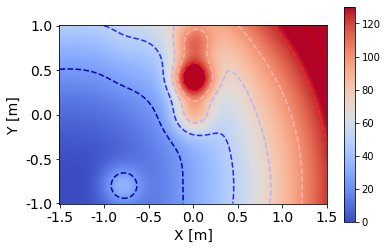

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)
# data_rotated = cost_map_IHMCE.reshape((50,50))
# Create a figure and axes
fig, ax = plt.subplots()

# Custom normalization range
vmin = 0  # minimum value
vmax = 130  # maximum value

# Creating a custom normalization
norm = Normalize(vmin=vmin, vmax=vmax)


# Create a heatmap using imshow()
heatmap = ax.imshow(data_rotated,cmap='coolwarm',norm=norm)

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')

# Add a colorbar
cbar = plt.colorbar(heatmap,shrink=0.99)

# Add labels and title
ax.set_xlabel('X [m]',fontsize=14)
ax.set_ylabel('Y [m]',fontsize=14)
#ax.set_title('Rotated Heatmap')

ax.invert_yaxis()


# Define the desired tick positions and labels for x and y axes
# Generate positions matching the data grid
x_positions = np.linspace(0, data_rotated.shape[1] - 1, 7)  # Match with labels
y_positions = np.linspace(0, data_rotated.shape[0] - 1, 5)  # Match with labels

# Define the labels
x_labels = np.linspace(-1.5, 1.5, 7)
y_labels = np.linspace(-1.0, 1.0, 5)

# Set the x and y ticks and corresponding labels
ax.set_xticks(x_positions)
ax.set_xticklabels([f"{x:.1f}" for x in x_labels], fontsize=14)

ax.set_yticks(y_positions)
ax.set_yticklabels([f"{y:.1f}" for y in y_labels], fontsize=14)

# Display the plot
plt.show()
# plt.savefig('Cost_Heat_Map_IHMCE.jpg',dpi=500,bbox_inches ='tight')

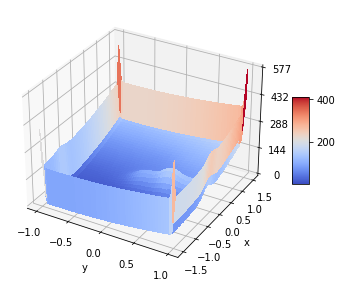

In [234]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import numpy as np


#fig = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.figure.set_figheight(20)
# Make data.
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)
X, Y = np.meshgrid(Y_axis, X_axis)


# Plot the surface.
surf = ax.plot_surface(X, Y, Cost_Map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(5))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.0f}')

ax.set_xlabel('y')
ax.set_ylabel('x')

#ax.view_init(90, 0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show()
# plt.savefig('3D_Cost_Map_estimated.jpg',dpi=1000,bbox_inches ='tight')

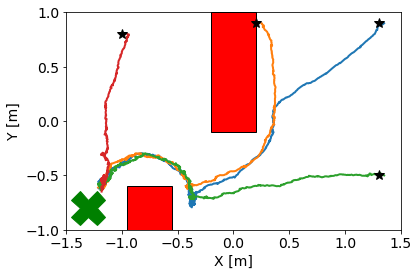

In [66]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]

plt.plot(-1.3,-0.8,'X',color='green',markersize=34)
# plt.plot(1.4,0.9,'x',color='white',markersize=5)


plt.plot(X_plot[0][:,0],X_plot[0][:,1],linewidth=2.0)
plt.plot(X_plot[1][:,0],X_plot[1][:,1],linewidth=2.0)
plt.plot(X_plot[2][:,0],X_plot[2][:,1],linewidth=2.0)
plt.plot(X_plot[3][:,0],X_plot[3][:,1],linewidth=2.0)

plt.plot(1.3,0.9,'*',color='black',markersize=10)
plt.plot(0.2,0.9,'*',color='black',markersize=10)
plt.plot(1.3,-0.5,'*',color='black',markersize=10)
plt.plot(-1.0,0.8,'*',color='black',markersize=10)


# plt.plot(1.32,0.9,'*',color='black',markersize=10)
# plt.plot(0.5,-0.2,'*',color='black',markersize=10)
# plt.plot(1.2,-0.5,'*',color='black',markersize=10)
# plt.plot(-0.5,0.25,'*',color='black',markersize=10)

# plt.plot(1.1,0.8,'*',color='black',markersize=10)
# plt.plot(0.5,-0.2,'*',color='black',markersize=10)
# plt.plot(-0.9,0.25,'*',color='black',markersize=10)
# plt.plot(-0.5,-0.4,'*',color='black',markersize=10)

# plt.plot(-1.1,0.9,'*',color='black',markersize=10)
# plt.plot(0.9,-0.2,'*',color='black',markersize=10)
# plt.plot(-0.7,0.5,'*',color='black',markersize=10)
# plt.plot(-0.5,0.25,'*',color='black',markersize=10)


# square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.95,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,-0.1), 0.4, 1.1, fc='red',ec="black")
plt.gca().add_patch(square2)
# plt.gca().add_patch(square1)
plt.gca().add_patch(square3)


plt.xticks([-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5],fontsize=14)  # Increase font size for x-tick labels
plt.yticks([-1.0,-0.5,0.0,0.5,1.0],fontsize=14)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]', fontsize=14)
plt.ylabel('Y [m]',fontsize=14)
plt.show()
# plt.savefig('Test_Trajectories_FPD_3.jpg',dpi=500,bbox_inches ='tight')
# plt.savefig('Test_Trajectories_DR_1.jpg',dpi=500,bbox_inches ='tight')

# plt.savefig('Test_Trajectories_DR_INV.jpg',dpi=500,bbox_inches ='tight')


# plt.savefig('Trajectory_Dataset_2.jpg',dpi=500,bbox_inches ='tight')

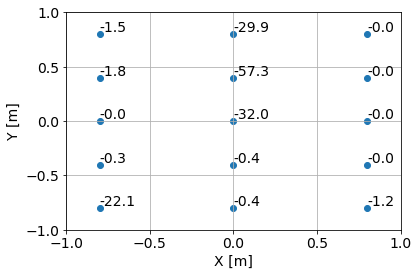

In [78]:
# Plotting feature points on the robotarium grid with correspopnding weights

import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.scatter(obs_points_f[0,:],obs_points_f[1,:])

w = np.zeros((15,))

for j in range(15):
    wt = float(weights[:,j+1])
    w[j] = round(wt,1)

for i, txt in enumerate(w.reshape(15,)):
    ax.annotate(txt,(obs_points_f[0,i],obs_points_f[1,i]+0.02), fontsize=14)

plt.grid(True)

plt.xticks([-1.0,-0.5,0.0,0.5,1.0],fontsize=14)
plt.yticks([-1.0,-0.5,0.0,0.5,1.0],fontsize=14)

plt.xlabel('X [m]',fontsize=14)
plt.ylabel('Y [m]',fontsize=14)

# plt.savefig('feature_point_grid.jpg',dpi=500,bbox_inches ='tight')
plt.show()

In [79]:
# To replicate the results can load the given data file
XX = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\State_Data_Simulation_DR_1.npy',allow_pickle=True)
# XX_Prev = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\State_Data_Simulation_Prev_1.npy',allow_pickle=True)
UU = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\Input_Data_Simulation_DR_1.npy',allow_pickle=True)
XN = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\State_Data_nom_1.npy',allow_pickle=True)
COVN = np.load(r'D:\Network Security\KL Control\robotarium_python_simulator\rps\examples\DR_Robotarium\COV_Data_nom.npy',allow_pickle=True)

In [80]:
# N_steps = 400 #np.array(XX[0]).shape[0]
M = 4

In [81]:
Eta = [0]*M
KLDA = [0]*M

for j in range(M):
    N_steps = np.array(XX[j]).shape[0]
    eta = np.zeros(N_steps)
    dkl = np.zeros(N_steps)
    for i in range(N_steps):
        x_nom = XN[j][i].reshape(2,)
        Covn = np.diag(np.array(COVN[j][i],dtype=float).reshape(2,))
        x = XX[j][i].reshape(2,)
        Cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        cov_reference = np.array([[0.00001, 0.000002], [0.000002, 0.00001]])
        DKL = calculate_kl_divergence(x,Cov,x_nom,Covn)
        eta[i] = np.clip(calculate_kl_divergence(goal_points[:-1].reshape((2,)),cov_reference,x_nom,Covn),0.0,100)
        dkl[i] = calculate_kl_divergence(x,Cov,x_nom,Covn)
    Eta[j] = eta
    KLDA[j] = dkl

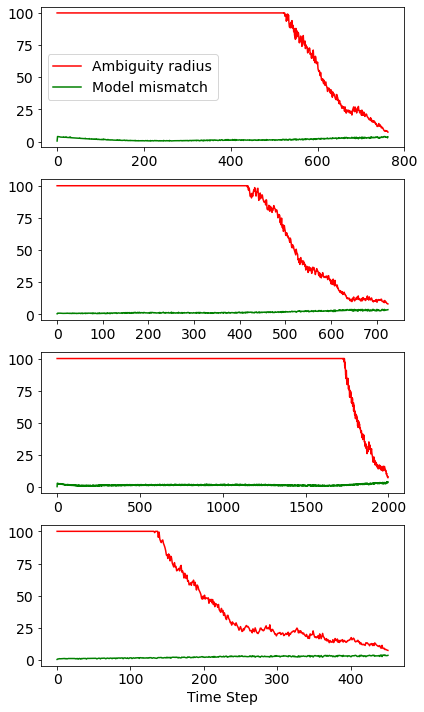

In [82]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig1, ax = plt.subplots(M, 1)  # Create subplots
fig1.set_figwidth(6)  # Set figure width
fig1.set_figheight(10)  # Set figure height

for j in range(M):
    ax[j].plot(Eta[j], 'r', label=r'Ambiguity radius')  # Add label for legend
    ax[j].plot(KLDA[j], 'g',label=r'Model mismatch')  # Add label for legend
    ax[M-1].set_xlabel('Time Step', fontsize=14)  # Set x-axis label with fontsize

    # Set tick label sizes
    ax[j].tick_params(axis='both', labelsize=14)

    # Set y-axis label (if needed)
    # ax[j].set_ylabel(f'Plot {j+1}', fontsize=14)  

# Set legend with fontsize
ax[0].legend(prop={'size':14}, ncol=1, loc='center left')
plt.tight_layout()
plt.show()
# plt.savefig('Eta_V_KL_3.jpg',dpi=300)
